In [0]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


In [0]:
from rl.algs.pg import *

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


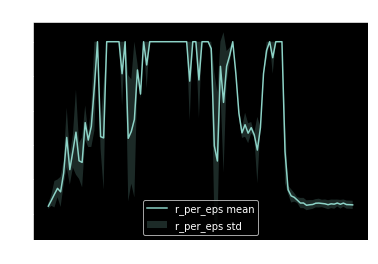

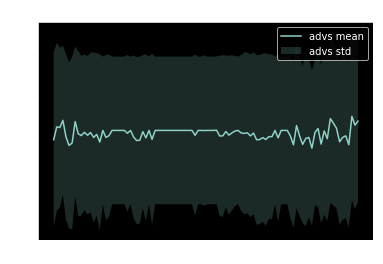

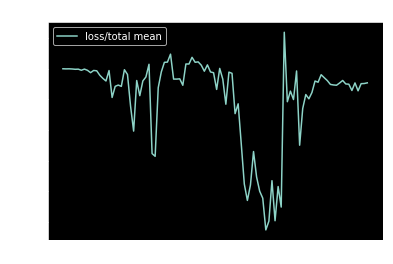

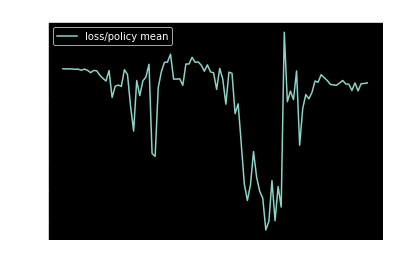

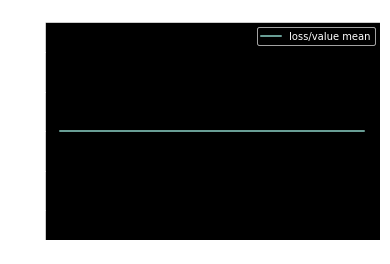

In [3]:
# Discrete task, no NN baseline
env_name = 'CartPole-v1'
train_params = TrainParams(
  num_train_iters=500,
  steps_per_batch=500,
  steps_per_snapshot=5,
  lr=0.005,
  discount=0.99,
)
model_params = {
  'hidden_layers': (128,),
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [4]:
exps['CartPole-v1'].visualize(num_episodes=1)


Step: 380. Expected reward: 500.0
Reward: mean 500.00, std 0.00 over 1 episodes.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Actual rewards: [[500.0]]


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/z/code/z/src/rl/algs/model.py:175: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  th.nn.init.xavier_normal(m.weight, gain=1e-2)


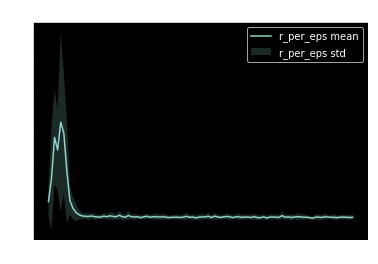

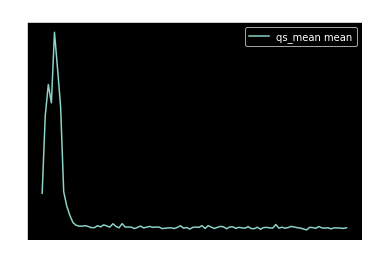

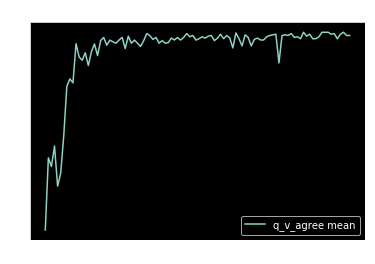

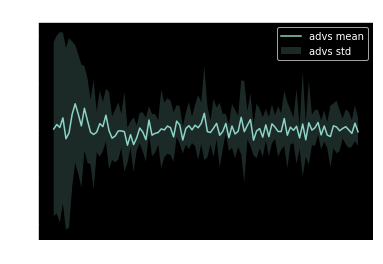

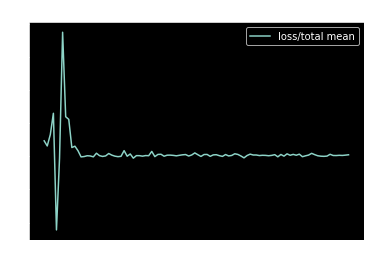

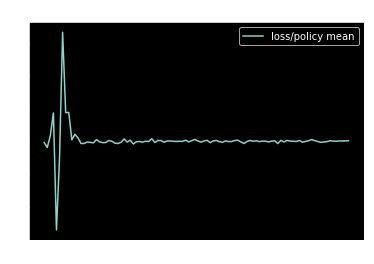

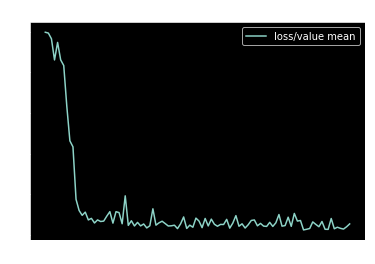

In [5]:
# Discrete task, NN baseline
env_name = 'CartPole-v1'
train_params = TrainParams(
  num_train_iters=500,
  steps_per_batch=500,
  steps_per_snapshot=5,
  lr=0.005,
  discount=0.99,
)
model_params = {
  'hidden_layers': (128,),
}
value_nn_params = {
  'hidden_layers': (128, 128,),
}
exp = Experiment(env_name, train_params, model_params, value_nn_params)
exps[env_name] = exp
exp.train()


In [6]:
exps['CartPole-v1'].visualize(num_episodes=5)

Step: 20. Expected reward: 64.375
Reward: mean 39.80, std 25.31 over 5 episodes.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Actual rewards: [[46.0, 19.0, 17.0, 86.0, 31.0]]


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'roboschool.gym_pendulums.RoboschoolInvertedPendulum'>' has deprecated methods. Compatibility code invoked.


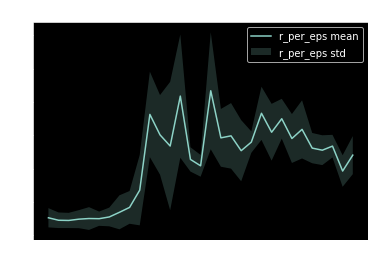

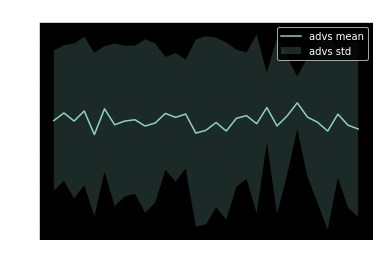

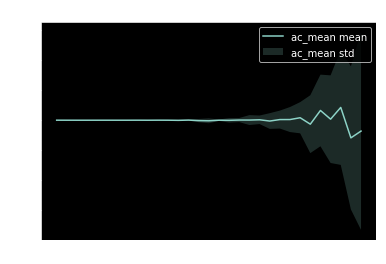

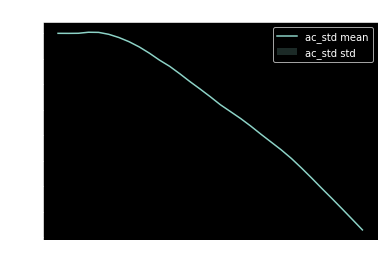

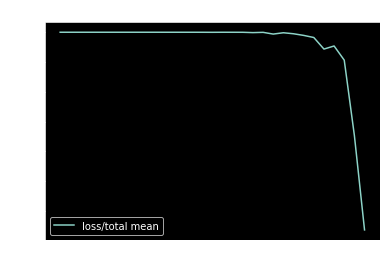

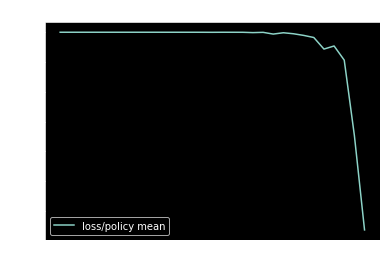

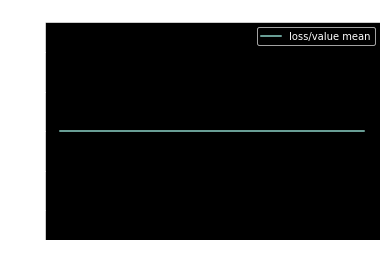

In [7]:
# Continuous task, no NN baseline.
import roboschool

env_name = 'RoboschoolInvertedPendulum-v1'
train_params = TrainParams(
  num_train_iters=151,
  steps_per_batch=1000,
  steps_per_snapshot=5,
  lr=0.001,
  discount=0.9,
)
model_params = {
  'shared_layers': (64,) * 3,
  'action_layers': (64,) * 1,
  'model_std': False,
  'min_std': None,
}
value_nn_params = {
  'hidden_layers': (4,),
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [0]:
exps['RoboschoolInvertedPendulum-v1'].visualize(num_episodes=3)